**Introduction to Remote sensing**


*   Search for satellite data using stac api
*   compute vegetation indices
*   Turn into dataframe



In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install pystac-client rasterio geopandas  pyproj matplotlib numpy pandas
  !pip install rioxarray
  !pip install leafmap



In [ ]:
from pystac_client import Client
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import logging
import leafmap
import json
from PIL import Image
import io
import pandas as pd
from shapely.geometry import mapping, shape

In [ ]:
log = logging.getLogger(__name__)
from google.colab import output
output.enable_custom_widget_manager()

Define the API endpoint and initialize the client

In [ ]:

stac_url = 'https://earth-search.aws.element84.com/v1'
client = Client.open(stac_url)


Area of interest (AOI) you can use `https://geojson.io/` or tools like geopandas to read vector datasets like geojson, shapefile etc

In [ ]:
# Define a GeoJSON feature collection for the search
feature_collection = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              35.28454030487018,
              0.608859946342605
            ],
            [
              35.28454030487018,
              0.5950215493423343
            ],
            [
              35.30426287483857,
              0.5950215493423343
            ],
            [
              35.30426287483857,
              0.608859946342605
            ],
            [
              35.28454030487018,
              0.608859946342605
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

Check collections available in the api

In [ ]:
collections = client.get_collections()


In [ ]:
for collection in collections:
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


To find more information about a collection we cab use the get_collection element

In [ ]:
s2_collection = client.get_collection('sentinel-2-l2a')
s2_collection

<CollectionClient id=sentinel-2-l2a>

Band names


In [ ]:
s2_collection.item_assets.keys()

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])

Search for images that intersects a geometry (our AOI)

In [ ]:
type_location_geojson = feature_collection["type"]
if type_location_geojson not in ["Point", "Polygon", "feature", "FeatureCollection"]:

            raise ValueError("Only Point and Polygon types are supported.")

if type_location_geojson == "FeatureCollection":
        feature_collection = feature_collection["features"][0]["geometry"]
        log.debug("FeatureCollection detected. Using the first feature as the location.")

In [ ]:
# Define collections

collections = ['sentinel-2-l2a']

In [ ]:
search = client.search(
        intersects=feature_collection,
        collections=collections,
        limit=10
    )

In [ ]:
search.matched()

768

Investigate an item

In [ ]:
items = search.item_collection()

In [ ]:
len(items)

768

In [ ]:
items[0]

<Item id=S2B_36NYF_20250204_0_L2A>

In [ ]:
print(items[0].datetime)

2025-02-04 08:09:58.737000+00:00


In [ ]:
items[0].geometry

{'type': 'Polygon',
 'coordinates': [[[34.79692496065105, 0.904454597926715],
   [34.79670462901768, -0.08842989004716482],
   [35.782627318077395, -0.08836865758220262],
   [35.78296824145847, 0.9038282672418553],
   [34.79692496065105, 0.904454597926715]]]}

Create a geojson from the geometry

In [ ]:
geojson_header = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {}
    }
  ]
}

In [ ]:
geojson_header['features'][0]['geometry'] = items[0].geometry

In [ ]:
geojson_header

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[34.79692496065105, 0.904454597926715],
      [35.78296824145847, 0.9038282672418553],
      [35.782627318077395, -0.08836865758220262],
      [34.79670462901768, -0.08842989004716482],
      [34.79692496065105, 0.904454597926715]]]}}]}

Visualize it

In [ ]:
m = leafmap.Map(center=[0.608859946342605,35.28454030487018,
              ], zoom=8, height="800px")
m.add_geojson(geojson_header , layer_name="AOI")
m

Map(center=[0.608859946342605, 35.28454030487018], controls=(ZoomControl(options=['position', 'zoom_in_text', …

**Query Metadata**

Items in STAC catalog have much more metadata (in addition to location) that you can query and only return results that match your query parameters. Let’s use the datetime property and only search for scenes in 2021

In [ ]:
datetime = "2021-01-01/2021-01-31"

In [ ]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=feature_collection,
    datetime=datetime
)


In [ ]:
search.matched()

12

Searching with cloud cover

In [ ]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=feature_collection,
    datetime=datetime,
    query=["eo:cloud_cover<5"],
    limit=10
)

In [ ]:
search.matched()

5

Sorting by a metadata during search

In [ ]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=feature_collection,
    datetime=datetime,
    query=["eo:cloud_cover<5"],
    limit=10
)

In [ ]:
items = search.item_collection()

In [ ]:
len(items)

5

In [ ]:
for item in items:
    print(item.properties["eo:cloud_cover"])

0.135514
0.133795
0.035657
1.840714
3.103361


You can also save the results of the search into a JSON file if you need it later on.

Create stack Items and xarray Dataset

In [ ]:
items.save_object("search.json")

Access Assets

In [ ]:
#Let's look at the second item:
selected_item = items[1]

In [ ]:
# Here are the assets available for this item
assets = selected_item.assets
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [ ]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

Each asset has a link which can be accessed from the href property. This can be a HTTP URL or a link to S3 for this STAC catalog. For example, let’s look at the link for the thumbnail of the scene.

In [ ]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/N/YF/2021/1/S2A_36NYF_20210131_1_L2A/thumbnail.jpg


Since this is a HTTP link, we can use Python requests package to load the image.

In [ ]:
import requests
img_data = requests.get(assets["thumbnail"].href).content

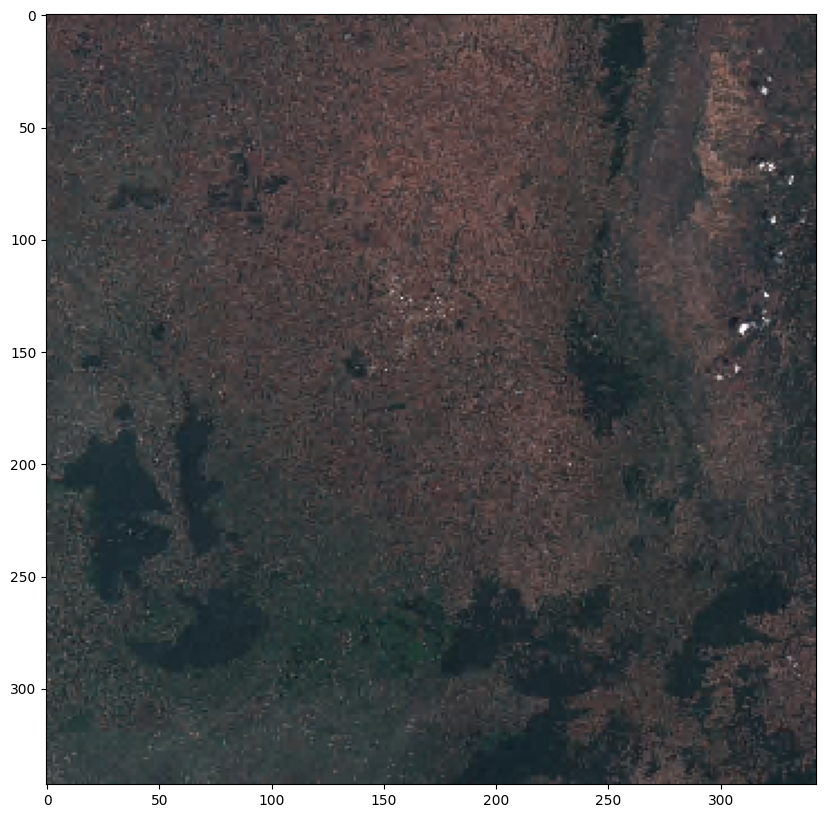

In [ ]:

plt.figure(figsize=(10, 10))
plt.imshow(Image.open(io.BytesIO(img_data)))

Now, let’s load one of the COG assets into memory. This is a large scene, and we don’t necessary want to load all the data at once. There are various packages to do this. Here we will use rioxarray, you can also use stacstack and odc-stac.

In [ ]:
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
nir

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.098e+05
  * y            (y) float64 88kB 1e+05 1e+05 1e+05 ... -9.765e+03 -9.775e+03
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

Note: At this stage the nir DataArray that we defined is empty, and only the metadata of the scene is loaded from the target href. This is consistent with open_rasterio function behavior, and you will learn more about it later in the class. When you run any function on nir or call any of the built-in function (e.g. mean()) the data will be loaded to memory.

First, let’s plot part of the nir array.

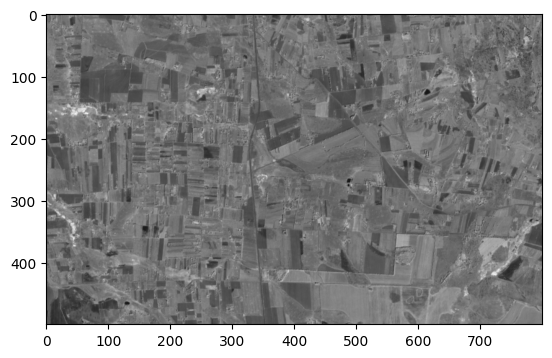

In [ ]:
plt.imshow(nir[0,1500:2000,6200:7000], cmap='gray')
plt.clim(vmin=10, vmax=5000)

In this case, only the portion of the array that we wanted to visualize was loaded.

We can actually time the operation of plotting the whole scene vs the small portion we selected, and see the efficiency of using this approach.

8.23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


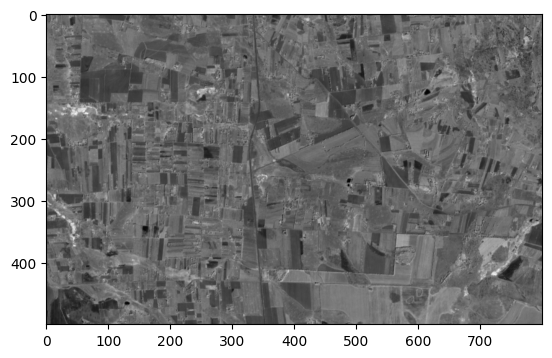

In [ ]:
%%timeit -n 5 -r 1
plt.imshow(nir[0,1500:2000,6200:7000], cmap='gray')

3.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


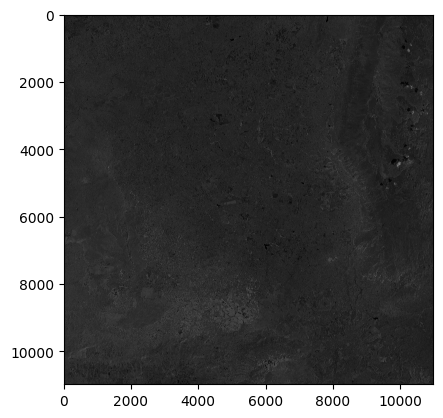

In [ ]:
%%timeit -n 5 -r 1
plt.imshow(nir[0, :, :], cmap='gray')

Saving as a GeoTIFF

In [ ]:
nir[0,1500:2000,6200:7000].rio.to_raster("nir_subset.tif")

Computing indices

In [ ]:
red = rioxarray.open_rasterio(assets["red"].href)

Create a subset dataset and scale it for indices computation

In [ ]:
red_subset = red[0,1500:2000,6200:7000] /10000
nir_subset = nir[0,1500:2000,6200:7000] / 10000

In [ ]:
ndvi = (nir_subset  - red_subset)/ (nir_subset  + red_subset)

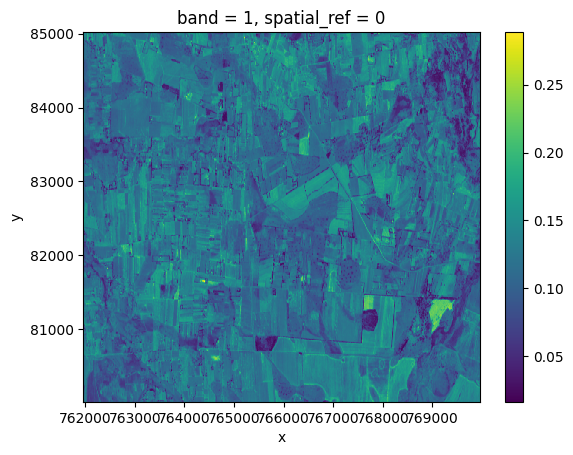

In [ ]:
red_subset.plot(cmap='viridis')


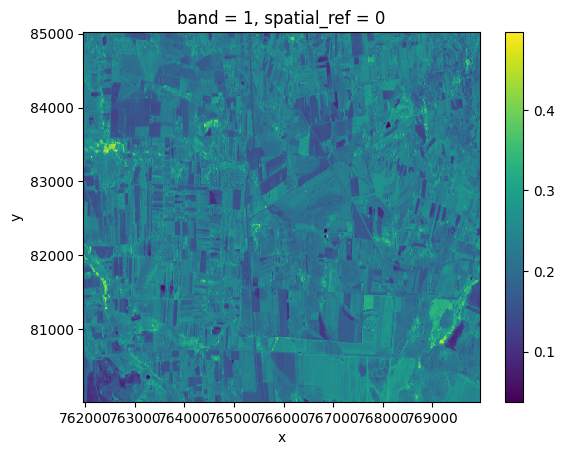

In [ ]:
nir_subset.plot(cmap='viridis')

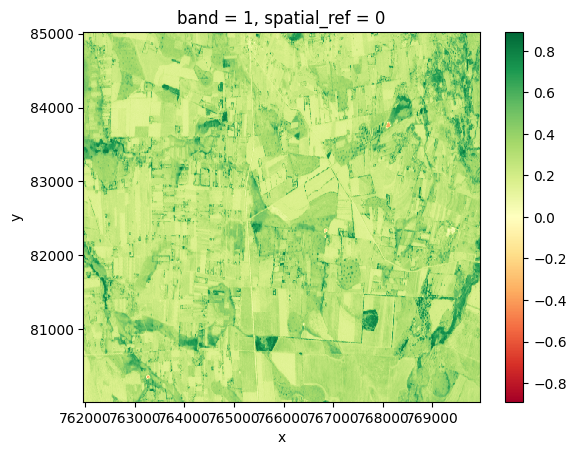

In [ ]:
ndvi.plot(cmap='RdYlGn')

In [ ]:
ndvi.name = 'ndvi'  # Assign a name to the DataArray
ndvi_df = ndvi.to_dask_dataframe()

In [ ]:
ndvi_df.tail()

,x,y,band,spatial_ref,ndvi
399995,769955.0,80065.0,1,0,0.263549
399996,769955.0,80055.0,1,0,0.261845
399997,769955.0,80045.0,1,0,0.260838
399998,769955.0,80035.0,1,0,0.252572
399999,769955.0,80025.0,1,0,0.254253


from matplotlib import pyplot as plt
_df_0['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ndvi'].plot(kind='hist', bins=20, title='ndvi')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='y', y='ndvi', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['x']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['x']
  ys = series['ndvi']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('ndvi')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['x']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'x'}, axis=1)
              .sort_values('x', ascending=True))
  xs = counted['x']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('x', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('x')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['band']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('band', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('band')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
_df_7['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['ndvi'].plot(kind='line', figsize=(8, 4), title='ndvi')
plt.gca().spines[['top', 'right']].set_visible(False)

Next steps
Look into xarray datasets